# base_rbt

> Base functions and classes we use for our hacking on BT / RBT and related ideas

## Install

```sh
!pip install git+https://github.com/hamish-haggerty/base_rbt.git#egg='base_rbt'
```

## How to use

After installing, import like this:

In [ ]:
from base_rbt.base_model import *
from base_rbt.base_lf import *

We also need some other libraries:


In [ ]:
import self_supervised
import torch
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

Now we give an end to end example. There are only a couple of steps. We first we need a dls i.e. a dataloader; then patch in our own definition of a loss funtion `lf`. Then it is a simple matter of defining an augmentation pipeline and fitting the model. We go through each of these now.
First, get some data:

In [ ]:
#Get some MNIST data and plonk it into a dls
path = untar_data(URLs.MNIST)
items = get_image_files(path/'training') #i.e. NOT testing!!!
items = items.shuffle()
items = items[0:10]
split = RandomSplitter(valid_pct=0.0)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=split(items))
dls = tds.dataloaders(bs=5,num_workers=0, after_item=[ToTensor(), IntToFloatTensor()], device=device)


Next we need to construct the `lf`. Here is a (silly!) modification to the BT loss function. We are just scaling the bt loss function by $0.01$. However, this illustrates the general API if we want to modify the loss function:

In [ ]:
@patch
def lf(self:BarlowTwins, pred,*yb): return 0.01*lf_bt(pred, self.I,self.lmb)

Now we patch in our own definition of a loss function, using the tools from `base_lf`.  First define it:

In [ ]:
def lf_rbt(pred,seed,I,lmb):
    
    bs,nf = pred.size(0)//2,pred.size(1)

    #All standard, from BT
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
    C = (z1norm.T @ z2norm) / bs 
    cdiff = (C - I)**2

    #Get either max corr(f(x),g(y)) {if indep=True} or max 0.5*corr(x,g(y)) + 0.5*corr(f(x),y), {if indep=False}
    #where the max is over f and g. Please see base_lf for details
    CdiffSup = Cdiff_Sup(I=I,qs=ps,inner_steps=5,indep=False)
    cdiff_2 = CdiffSup(z1norm,z2norm) #same shape as cdiff

    #As above but f and g are now randomly sampled sinusoid. Please see base_lf for details
    CdiffRand = Cdiff_Rand(seed=seed,std=0.1,K=2,indep=False)
    cdiff_2_2 = CdiffRand(z1norm,z2norm) #same shape as cdiff

    cdiff_2 = 0.5*cdiff_2_2 + 0.5*cdiff_2 #convex combination of rand and sup terms.

    rr = cdiff_2*(1-I)*lmb #redundancy reduction term (scaled by lmb)

    loss = (cdiff*I + rr).sum() #sum of redundancy reduction term and invariance term
    torch.cuda.empty_cache()
    return loss

This loss function has both a `random` component and a `sup` component.
Next patch it in:

In [ ]:
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_rbt(pred,seed=self.seed,I=self.I,lmb=self.lmb)

We now need an augmentation pipeline. Let's also take a look at what it looks like. 

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 'prob': 0.5, 's': 11, 's1': 3, 'same_on_batch': False} -> Normalize -- {'mean': tensor([[[[0.1310]]]]), 'std': tensor([[[[0.3080]]]]), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 'prob': 0.5, 's': 11, 's1': 3, 'same_on_batch': False} -> Normalize -- {'mean': tensor([[[[0.1310]]]]), 'std': tensor([[[[0.3080]]]]), 'axes': (0, 2, 3)}


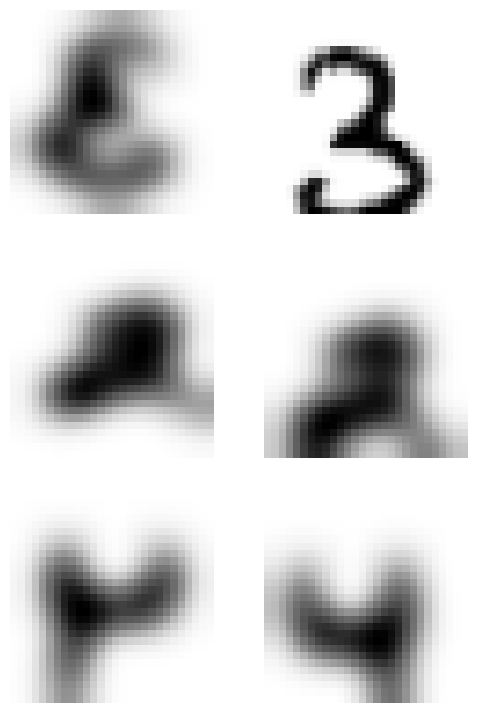

In [ ]:
n_in=1
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=1)
model = create_barlow_twins_model(fastai_encoder, hidden_size=10,projection_size=10)# projection_size=1024)

aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=28,
                    rotate=False,jitter=False,bw=False,blur=True,solar=False, #Whether to use aug or not
                    resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3), rotate_deg=45,blur_s=11,s1=3,sol_t=0.05,sol_a=0.05, #hps of augs
                    flip_p=0.5, rotate_p=0.3, jitter_p=0.3, bw_p=0.3, blur_p=0.5,sol_p=0.1, #prob of performing aug
                    same_on_batch=False,stats=mnist_stats, cuda=(device=='cuda'))

aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=28,
                    rotate=False,jitter=False,bw=False,blur=True,solar=False, #Whether to use aug or not
                    resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3), rotate_deg=45,blur_s=11,s1=3,sol_t=0.05,sol_a=0.05, #hps of augs
                    flip_p=0.5, rotate_p=0.3, jitter_p=0.3, bw_p=0.3, blur_p=0.5,sol_p=0.1, #prob of performing aug
                    same_on_batch=False,stats=mnist_stats, cuda=(device=='cuda'))

aug_pipelines = [aug_pipelines_1,aug_pipelines_1]
tem = BarlowTwins(aug_pipelines,n_in=n_in,print_augs=True)
learn = Learner(dls,model, cbs=[tem])
b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=3)

Finally,let's train RBT; We construct an encoder and a learner, then fit it. 

In [ ]:
#Full usage of above
ps=500 #projection size
hs=ps #hidden size in mlp at the end; typically just = ps. 
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=1) #create the encoder
model = create_barlow_twins_model(fastai_encoder, hidden_size=hs,projection_size=ps)#plonk the projector on the end of the encoder
learn = Learner(dls,model, cbs=[BarlowTwins(aug_pipelines,n_in=1, print_augs=False)]) #build the learner
learn.fit(1) #train model, i.e. weights of encoder and projector.

Once we have trained the `fastai_encoder` can evaluate in various ways. e.g. linear evaluation. 